# PROJECT OBJECTIVE: 

Build a sequential NLP classifier which can use input text parametersto determine the customer sentiments.

# DATA DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com.
This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article




**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read Data**

In [4]:
dframe = pd.read_json('/content/drive/MyDrive/My Drive/AIML/NLP/NLP2/Sarcasm_Headlines_Dataset.json',lines = True)
dframe.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
dframe.shape

(26709, 3)

In [6]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
dframe.isna().any()

article_link    False
headline        False
is_sarcastic    False
dtype: bool

In [8]:
print('Unique values in Label/Target(Dependent) Column:' , dframe['is_sarcastic'].unique())
print('Unique values in Feature(Independent) Column:', dframe['headline'].nunique()) 
print('Unique values in Article Link (Required to Drop):', dframe['article_link'].nunique())

Unique values in Label/Target(Dependent) Column: [0 1]
Unique values in Feature(Independent) Column: 26602
Unique values in Article Link (Required to Drop): 26708


In [9]:
dframe['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


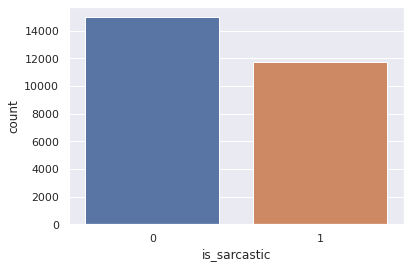

In [10]:
sns.set(style="darkgrid")
sns.countplot(dframe['is_sarcastic'])

**Drop Unwanted Features**

In [11]:
dframe.drop(['article_link'],axis = 1, inplace = True)
dframe.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [12]:
# Drop Duplicate Values
dframe[dframe.duplicated(['headline','is_sarcastic'])].count()

headline        107
is_sarcastic    107
dtype: int64

In [13]:
dframe.drop_duplicates(subset=['headline','is_sarcastic'],inplace = True)
dframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26602 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26602 non-null  object
 1   is_sarcastic  26602 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 623.5+ KB


In [14]:
dframe[dframe.duplicated(['headline','is_sarcastic'])].count()

headline        0
is_sarcastic    0
dtype: int64

**Get length of each sentence**

In [15]:
measurer = np.vectorize(len)
measurer(dframe['headline'].astype(str))

array([78, 84, 79, ..., 21, 60, 33])

In [16]:
for a in dframe['headline']:
  if len(a) > 230:
    print(len(a))

237
238
254


In [17]:
measurer(dframe['headline'].astype(str)).max()

254

In [18]:
maxlen = max([len(txt) for txt in dframe['headline']])
print('Maximum Sentence Length: ', maxlen)

Maximum Sentence Length:  254


**Set Different Parameters**

In [19]:
max_features = 10000
embedding_size = 300

In [20]:
headline_text = dframe['headline']

In [21]:
#Tokenizer for headline column
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(headline_text)

In [22]:
headline_text.head(4)

0    former versace store clerk sues over secret 'b...
1    the 'roseanne' revival catches up to our thorn...
2    mom starting to fear son's web series closest ...
3    boehner just wants wife to listen, not come up...
Name: headline, dtype: object

In [23]:
X = tokenizer.texts_to_sequences(headline_text)
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(dframe['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26602
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  

In [24]:
vocab_size = len(tokenizer.word_index)
print('vocablury size: ', vocab_size)

vocablury size:  29656


In [25]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'trump': 12,
 'man': 13,
 'from': 14,
 'at': 15,
 'about': 16,
 'you': 17,
 'by': 18,
 'this': 19,
 'after': 20,
 'up': 21,
 'out': 22,
 'be': 23,
 'how': 24,
 'as': 25,
 'it': 26,
 'that': 27,
 'not': 28,
 'are': 29,
 'your': 30,
 'his': 31,
 'what': 32,
 'he': 33,
 'all': 34,
 'just': 35,
 'who': 36,
 'has': 37,
 'will': 38,
 'more': 39,
 'one': 40,
 'report': 41,
 'into': 42,
 'year': 43,
 'why': 44,
 'have': 45,
 'area': 46,
 'over': 47,
 'donald': 48,
 'u': 49,
 'day': 50,
 's': 51,
 'says': 52,
 'can': 53,
 'first': 54,
 'woman': 55,
 'time': 56,
 'like': 57,
 'her': 58,
 "trump's": 59,
 'old': 60,
 'no': 61,
 'get': 62,
 'off': 63,
 'an': 64,
 'life': 65,
 'people': 66,
 'obama': 67,
 'now': 68,
 'house': 69,
 'still': 70,
 'make': 71,
 'was': 72,
 'than': 73,
 "'": 74,
 'white': 75,
 'back': 76,
 'women': 77,
 'my': 78,
 'i': 79,
 'clinton': 80,
 'down': 81,
 'i

**Glove Word Embeddings**

In [26]:
embeddings = {}
for o in open('/content/drive/MyDrive/My Drive/AIML/NLP/NLP2/glove.6B.300d.txt'):
    word = o.split(" ")[0]    
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')    
    embeddings[word] = embd

**Weight matrix for words**

In [27]:
num_words = vocab_size +1

In [28]:
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

**Create and Compile your Model**

In [29]:
model = Sequential()

model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))

model.add(Dropout(0.2))

### Bidirectional LSTM layer for hint 
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

In [30]:
model.output

<KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'dense')>

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         8897100   
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           257       
Total params: 9,336,653
Trainable params: 9,336,653
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

**Fit the model**

In [33]:
batch_size = 100
epochs = 5
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
model.fit(X_train,y_train,epochs=epochs ,batch_size=batch_size,validation_data=(X_test, y_test),verbose = 1)

Epoch 1/5
213/213 [==============================] - 39s 141ms/step - loss: 0.5904 - accuracy: 0.6999 - val_loss: 0.4907 - val_accuracy: 0.8038
Epoch 2/5
213/213 [==============================] - 29s 136ms/step - loss: 0.6079 - accuracy: 0.6602 - val_loss: 0.5223 - val_accuracy: 0.7759
Epoch 3/5
213/213 [==============================] - 29s 135ms/step - loss: 0.5889 - accuracy: 0.6703 - val_loss: 0.6802 - val_accuracy: 0.5577
Epoch 4/5
213/213 [==============================] - 29s 136ms/step - loss: 0.6708 - accuracy: 0.5745 - val_loss: 0.6724 - val_accuracy: 0.5583
Epoch 5/5
213/213 [==============================] - 29s 137ms/step - loss: 0.5562 - accuracy: 0.6938 - val_loss: 0.5815 - val_accuracy: 0.7080
